In [1]:
import pandas
import numpy
import datetime
import os
import re
import seaborn as sns
import aacgmv2
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
from matplotlib import ticker
from matplotlib.dates import date2num, DateFormatter, MinuteLocator
from matplotlib.ticker import FuncFormatter, MaxNLocator
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
intMagDir = "../data/mag/"
inpDate = datetime.datetime(2011,7,5)#datetime.datetime(2011,5,16)#datetime.datetime(2011,6,8)#
inpDateRng = [ datetime.datetime(2011,7,5,0),\
              datetime.datetime(2011,7,5,12) ]
# [ datetime.datetime(2011,5,16,7),\
#               datetime.datetime(2011,5,16,10) ]

# selStations = [ "cmo", "ykc", "fcc", "pbq", \
#                "sit", "mea", "gln", "frd", \
#                "ott", "vic", "new", "bou" ]
selStations = [ "mea", "ott" ]
inpColNames = [ "dateStr", "timeStr", "doy",\
              "X", "Y", "Z", "G" ]

In [3]:
def convert_to_datetime(row):
    return datetime.datetime( \
        int(row["dateStr"].split("-")[0]),\
        int(row["dateStr"].split("-")[1]),\
        int(row["dateStr"].split("-")[2]),\
        int(row["timeStr"].split(":")[0]),\
        int(row["timeStr"].split(":")[1]) )

In [4]:
def convert_geo_to_aacgm(row):
    """
    Get MLAT, MLON, MLT from GLAT, GLON
    and time!
    """
    mlat, mlon = aacgmv2.convert(row["glat"],\
                        row["glon"], 300., row["date"])
    mlt = aacgmv2.convert_mlt(\
            mlon, row["date"], m2a=False)
    return [round(float(mlat),2), round(float(mlon),2), round(float(mlt),2)]

In [5]:
frameList = []
intMagDir = "../data/mag/"
for subdir, dirs, files in os.walk(intMagDir):
    if inpDate.strftime("%Y%m%d") in subdir:
        for currFile in files:
            if inpDate.strftime("%Y%m%d") in currFile:
                # sometimes there are variable number of lines
                # in the file, get them
                file = open(subdir + "/" + currFile, "r")
                allLines = file.readlines()
                currLN = 1
                isColLine = False
                isBadFile = False
                while not isColLine:
                    currLN += 1
                    # skip if currLN exceeds len of allLines
                    if currLN + 10 > len(allLines):
                        print "no data found--->", currFile
                        isBadFile = True
                        break
                    # get lat lon of the station
                    if "Latitude" in allLines[currLN]:
                        currGlat = [float(s) for s in \
                                    re.findall(r'-?\d+\.?\d*',\
                                    allLines[currLN])][0]
                    if "Longitude" in allLines[currLN]:
                        currGlon = [float(s) for s in \
                                    re.findall(r'-?\d+\.?\d*',\
                                    allLines[currLN])][0]
                    if ("DATE" in allLines[currLN]) & ("TIME" in allLines[currLN]):
                        currLN += 1
                        isColLine = True
                file.close()
                if not isBadFile:
                    currDF = pandas.read_csv( subdir + "/" + currFile,\
                                    skiprows=currLN, names=inpColNames,\
                                    delim_whitespace=True )
                    currDF["station"] = currFile[0:3]
                    currDF["glat"] = currGlat
                    currDF["glon"] = currGlon
                    # convert the mlat, mlon and mlt!
                    currDF["date"] = currDF.apply( \
                                convert_to_datetime, axis=1 )
                    # To avoid duplicating values set GLAT, GLON to None
                    currGlat = None
                    currGlon = None
                    frameList.append( currDF )
                isBadFile = False
# Merge the data into a single DF
intMagDF = pandas.concat( frameList )
# get MLAT, MLON and MLT
intMagDF[ ["mlat", "mlon", "mlt"] ] = intMagDF.apply( \
                        lambda row: pandas.Series(\
                        convert_geo_to_aacgm(row)), axis=1 )
intMagDF["H"] = numpy.sqrt( numpy.square( intMagDF["X"] ) +\
                           numpy.square( intMagDF["Y"] ) )
intMagDF["D"] = numpy.rad2deg( numpy.arctan(\
                            intMagDF["Y"] / intMagDF["X"] ) )
intMagDF = intMagDF[ [ "date", "station", "mlat",\
                "mlon", "mlt", "H", "D", "Z" ] ]
intMagDF.head()

no data found---> thg_l2_mag_whit_20110705_v01.cdf
no data found---> thg_l2_mag_brw_20110705_v01.cdf
no data found---> thg_l2_mag_kako_20110705_v01.cdf
no data found---> thg_l2_mag_ott_20110705_v01.cdf
no data found---> thg_l2_mag_nur_20110705_v01.cdf
no data found---> thg_l2_mag_mea_20110705_v01.cdf
no data found---> thg_l2_mag_stfd_20110705_v01.cdf
no data found---> thg_l2_mag_lrg_20110705_v01.cdf
no data found---> thg_l2_mag_muo_20110705_v01.cdf
no data found---> thg_l2_mag_pel_20110705_v01.cdf
no data found---> thg_l2_mag_iglo_20110705_v01.cdf
no data found---> thg_l2_mag_rank_20110705_v01.cdf
no data found---> thg_l2_mag_blc_20110705_v01.cdf
no data found---> thg_l2_mag_mas_20110705_v01.cdf
no data found---> thg_l2_mag_ded_20110705_v01.cdf
no data found---> thg_l2_mag_ukia_20110705_v01.cdf
no data found---> thg_l2_mag_ouj_20110705_v01.cdf
no data found---> thg_l2_mag_loys_20110705_v01.cdf
no data found---> thg_l2_mag_pg1_20110705_v01.cdf
no data found---> thg_l2_mag_gbay_20110705_

,date,station,mlat,mlon,mlt,H,D,Z
0,2011-07-05 00:00:00,gui,18.79,60.71,23.40,27645.641757,-8.146047,22901.7
1,2011-07-05 00:01:00,gui,18.79,60.71,23.41,27646.037535,-8.144464,22901.8
2,2011-07-05 00:02:00,gui,18.79,60.71,23.43,27646.108194,-8.144024,22901.7
3,2011-07-05 00:03:00,gui,18.79,60.71,23.44,27645.938375,-8.143028,22901.6
4,2011-07-05 00:04:00,gui,18.79,60.71,23.46,27646.207023,-8.142529,22901.5


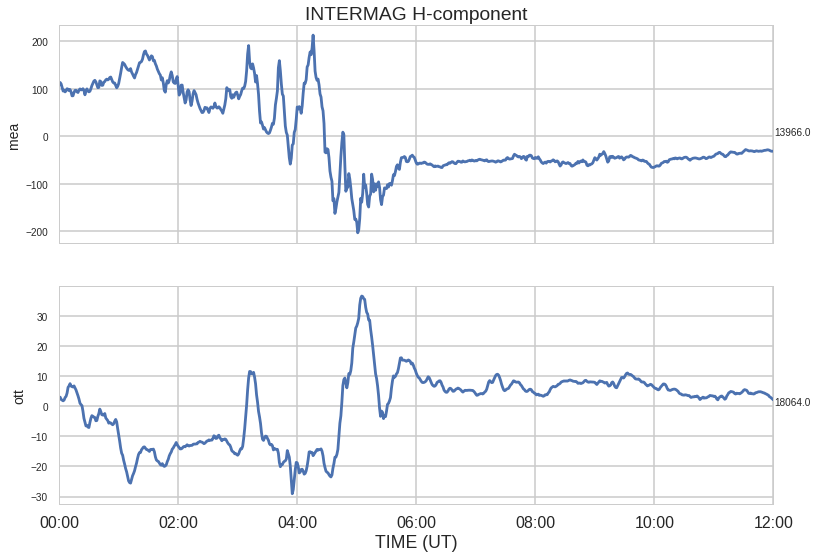

In [6]:
# plot the data
sns.set_style("whitegrid")
sns.set_context("poster")
pltMagcomp = "H"
# some stations we need may be missing data
# discard those stations.
# build a stationDF
stnDF = intMagDF[ ["station", "mlat", "mlon"]\
                    ].drop_duplicates(['station'],\
                    keep='first')
# select only those stations which are in our list
stnDF = stnDF[ stnDF["station"].isin(selStations) ]
# sort by MLAT, MLON
stnDF = stnDF.sort_values(by=["mlat", "mlon"],ascending=False)
finStations = list(stnDF["station"].values)
f = plt.figure(figsize=(12, 8))
f, axArr = plt.subplots(len(finStations), sharex=True)
for ind,stn in enumerate(finStations):
    currStnDF = intMagDF[ (intMagDF["station"] == stn) &\
                    (intMagDF["date"] >= inpDateRng[0] ) &\
                    (intMagDF["date"] <= inpDateRng[1] ) ]
    pltMagcomp = "H"
    meanMagFld = currStnDF[pltMagcomp].mean()
    # Plot values
    pltYData = currStnDF[pltMagcomp].values-meanMagFld
    axArr[ind].plot(currStnDF["date"].values, pltYData)
#     axArr[ind].text(0.8, 0.9, str(meanMagFld), size='small')
    axArr[ind].annotate(str(round(meanMagFld)), (date2num(inpDateRng[1]), pltYData.mean()), xytext=(1, 1), 
            textcoords='offset points',fontsize=10)
    # set X-axis formatter and limit
    axArr[ind].get_xaxis().set_major_formatter(DateFormatter('%H:%M'))
    axArr[ind].set_xlim( [inpDateRng[0], inpDateRng[1]] )
    axArr[ind].set_ylabel( stn, fontsize=14 )
    # set y-axis font size
    axArr[ind].yaxis.set_tick_params(labelsize=10)
        
        
axArr[-1].set_xlabel("TIME (UT)")
axArr[0].set_title("INTERMAG " + pltMagcomp + "-component")
f.savefig( "../plots/mag-" + pltMagcomp + "-comp" + ".pdf",bbox_inches='tight' )

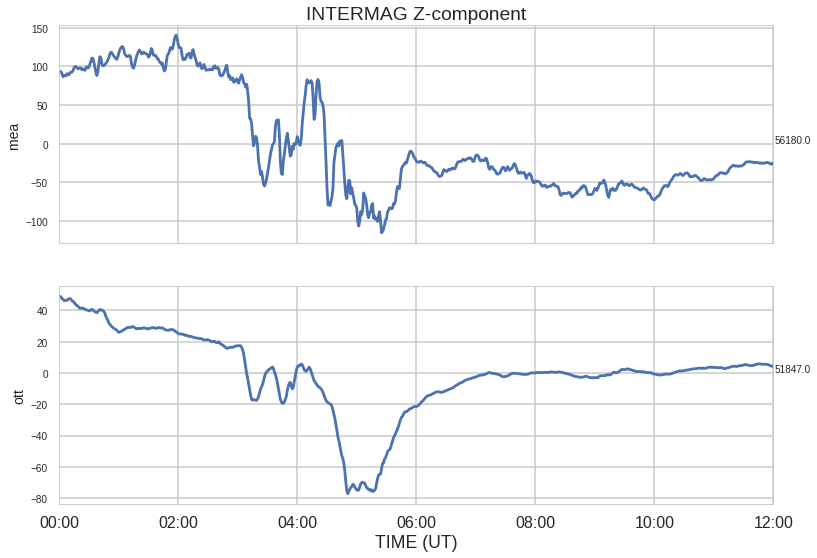

In [7]:
# plot the data
sns.set_style("whitegrid")
sns.set_context("poster")
pltMagcomp = "Z"
# some stations we need may be missing data
# discard those stations.
# build a stationDF
stnDF = intMagDF[ ["station", "mlat", "mlon"]\
                    ].drop_duplicates(['station'],\
                    keep='first')
# select only those stations which are in our list
stnDF = stnDF[ stnDF["station"].isin(selStations) ]
# sort by MLAT, MLON
stnDF = stnDF.sort_values(by=["mlat", "mlon"],ascending=False)
finStations = list(stnDF["station"].values)
f = plt.figure(figsize=(12, 8))
f, axArr = plt.subplots(len(finStations), sharex=True)
for ind,stn in enumerate(finStations):
    currStnDF = intMagDF[ (intMagDF["station"] == stn) &\
                    (intMagDF["date"] >= inpDateRng[0] ) &\
                    (intMagDF["date"] <= inpDateRng[1] ) ]
    meanMagFld = currStnDF[pltMagcomp].mean()
    # Plot values
    pltYData = currStnDF[pltMagcomp].values-meanMagFld
    axArr[ind].plot(currStnDF["date"].values, pltYData)
#     axArr[ind].text(0.8, 0.9, str(meanMagFld), size='small')
    axArr[ind].annotate(str(round(meanMagFld)), (date2num(inpDateRng[1]), pltYData.mean()), xytext=(1, 1), 
            textcoords='offset points',fontsize=10)
    # set X-axis formatter and limit
    axArr[ind].get_xaxis().set_major_formatter(DateFormatter('%H:%M'))
    axArr[ind].set_xlim( [inpDateRng[0], inpDateRng[1]] )
    axArr[ind].set_ylabel( stn, fontsize=14 )
    # set y-axis font size
    axArr[ind].yaxis.set_tick_params(labelsize=10)
        
        
axArr[-1].set_xlabel("TIME (UT)")
axArr[0].set_title("INTERMAG " + pltMagcomp + "-component")
f.savefig( "../plots/mag-" + pltMagcomp + "-comp" + ".pdf",bbox_inches='tight' )

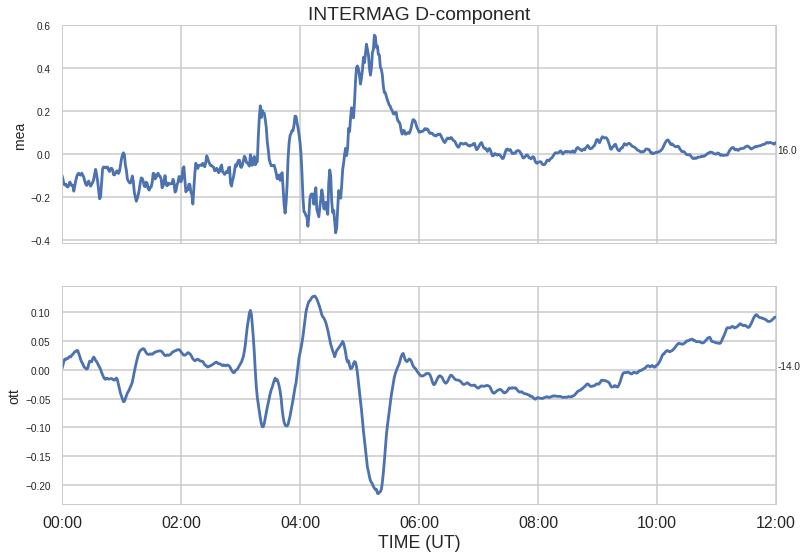

In [8]:
# plot the data
sns.set_style("whitegrid")
sns.set_context("poster")
pltMagcomp = "D"
# some stations we need may be missing data
# discard those stations.
# build a stationDF
stnDF = intMagDF[ ["station", "mlat", "mlon"]\
                    ].drop_duplicates(['station'],\
                    keep='first')
# select only those stations which are in our list
stnDF = stnDF[ stnDF["station"].isin(selStations) ]
# sort by MLAT, MLON
stnDF = stnDF.sort_values(by=["mlat", "mlon"],ascending=False)
finStations = list(stnDF["station"].values)
f = plt.figure(figsize=(12, 8))
f, axArr = plt.subplots(len(finStations), sharex=True)
for ind,stn in enumerate(finStations):
    currStnDF = intMagDF[ (intMagDF["station"] == stn) &\
                    (intMagDF["date"] >= inpDateRng[0] ) &\
                    (intMagDF["date"] <= inpDateRng[1] ) ]
    meanMagFld = currStnDF[pltMagcomp].mean()
    # Plot values
    pltYData = currStnDF[pltMagcomp].values-meanMagFld
    axArr[ind].plot(currStnDF["date"].values, pltYData)
#     axArr[ind].text(0.8, 0.9, str(meanMagFld), size='small')
    axArr[ind].annotate(str(round(meanMagFld)), (date2num(inpDateRng[1]), pltYData.mean()), xytext=(1, 1), 
            textcoords='offset points',fontsize=10)
    # set X-axis formatter and limit
    axArr[ind].get_xaxis().set_major_formatter(DateFormatter('%H:%M'))
    axArr[ind].set_xlim( [inpDateRng[0], inpDateRng[1]] )
    axArr[ind].set_ylabel( stn, fontsize=14 )
    # set y-axis font size
    axArr[ind].yaxis.set_tick_params(labelsize=10)
        
        
axArr[-1].set_xlabel("TIME (UT)")
axArr[0].set_title("INTERMAG " + pltMagcomp + "-component")
f.savefig( "../plots/mag-" + pltMagcomp + "-comp" + ".pdf",bbox_inches='tight' )